# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [11]:
import scipy.stats

In [12]:
import tensorflow as tf

In [13]:
import edward as ed
import edward.models

In [14]:
from sklearn import mixture

## Bayesian Model Selection

We [originally stated](Bayes.ipynb) Bayes' learning rule as:
$$
P(\Theta_M\mid D, M) = \frac{P(D\mid \Theta_M, M)\,P(\Theta_M\mid M)}{P(D\mid M)}
$$
in terms of the:
 1. **Posterior:** $P(\Theta_M\mid D, M)$ is the probability of the parameter values $\Theta_M$ given the data and the choice of hyperparameters.
 2. **Likelihood:** $P(D\mid \Theta_M, M)$ is the probability of the data given the model.
 3. **Prior:** $P(\Theta_M\mid M)$ is the probability of the model parameters given the hyperparameters and *marginalized over all possible data*.
 4. **Evidence:** $P(D\mid M)$ is the probability of the data given the hyperparameters and *marginalized over all possible parameter values given the hyperparameters*.

We often omit the model $M$ in our notation when we are only considering a single model. However, unless there is only one possible model, then we still have to solve a meta-inference problem of comparing possible models. Although this step is often referred to as "model selection", it is better to think of it as **model comparison**, since it can only assign relative probabilities to different models.

The posterior probability of a model $M$ given the observed data $D$ is:
$$
P(M\mid D) = \frac{P(D\mid M)\,P(M)}{P(D)} \; ,
$$
where the "evidence" given $M$, $P(D\mid M)$, is now in the numerator, and the denominator is now a "super evidence":
$$
P(D) = \int dM\, P(D\mid M)\,P(M) \; .
$$
In case of a countable (perhaps infinite) set of possible models, the integral becomes a sum,
$$
P(D) = \sum_k \, P(D\mid M_k)\, P(M_k) \; ,
$$
and each "model likelihood" $P(D\mid M_k)$ is a probability in the range $[0,1]$. We have also introduced a prior $P(M)$ on the model itself, marginalized over its parameter space:
$$
P(M) = \int d\Theta_M\, P(\Theta_M, M) \; .
$$
Note the similarity between this "Bayes' rule for models" and the original Bayes' rule.

We can now anticipate two problems for practical model comparisons:
 - We were able to perform inference for a given model without ever calculating its evidence $P(D\mid M)$, but that is no longer possible for model comparison.
 - To calculate the "super evidence" we must be able to specify *all possible models*.
 
However, we can sidestep the second problem if we only want to compare two possible models, $M_1$ and $M_2$, without specifying (or perhaps even knowing) the set of possible models. We use the **odds ratio** for this comparison,
$$
\text{odds ratio =}\quad
\frac{P(M_1\mid D)}{P(M_2\mid D)} = \frac{P(D\mid M_1)\, P(M_1)}{P(D\mid M_2)\,P(M_2)} \; ,
$$
where, conveniently, the "super evidence" $P(D)$ cancels in the ratio. The ratio of "model likelihoods" appearing on the right-hand side is known as the **Bayes factor**:
$$
\text{Bayes factor =}\quad
\frac{P(D\mid M_1)}{P(D\mid M_2)} \; .
$$

It is easy to lose sight of the big picture with all of this probability calculus, so let's zoom out to a simple example:

![Occam factor example](img/ModelSelection/OccamFactor.jpg)

**DISCUSS:** Study the observed image $D$ above with two models in mind:
 - $M_1$: The image shows a single piece of paper.
 - $M_2$: The image shows two pieces of paper.

Are both models possible? Give some arguments for why $M_2$ is unlikely. Are your arguments based on prior knowledge?

Both models are certainly possible since the ruler could be hiding the fact that these are two pieces of paper side by side.

However, $M_2$ is unlikely because:
 - This looks like a standard (US) sheet of paper, as supported its dimensions according to the ruler.
 - It would be a remarkable coincidence for two sheets of paper to be perfectly lined up like this.
 
The first argument is based on our prior knowledge, such as:
 - Standard (US) paper has the proportions 8.5 to 11.
 - Most (US) rulers are in inches.
 
Therefore, this type of argument shows up in the ratio of model priors, $P(M_1) / P(M_2)$ in the odds ratio above.
 
However, the second argument is a statement about probabilities that does not rely on any prior knowledge. Instead, it shows up in the Bayes factor above. To see how this happens, we need to define the parameters for each model. For each piece of paper, use four parameters:
 - $(x,y)$ of the top-left corner, which could be anywhere in the image.
 - width $w$ and height $h$ of the paper, which range over the full image width and height.
 
The likelihoods of $M_1$ and $M_2$ are then integrals over four and eight parameters, respectively:
$$
P(D\mid M_i) = \int d\Theta_i\, P(D, \Theta_i\mid M_i) \; .
$$
For $M_2$, the likelihood of the observed image $D$ will be zero except when the parameters of the second piece of paper have it line up perfectly under the ruler. Since this represents a small fraction of the full range of $M_2$ parameters, $P(D\mid M_2)$ is heavily penalized compared with $P(D\mid M_1)$, leading to a large Bayes factor.

This is an example of [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor) in action: Bayesian inference prefers the simplest explanation (model), independently of any prior knowledge.

---

## Case Study: How Many Peaks?

Generate some random samples of a single feature $x$ drawn from a mixture of two Gaussians:

In [15]:
def generate_mix(n_total, frac1, mu1, mu2, sigma1, sigma2, seed=123, plot_range=(-1.5, 1.5)):
    gen = np.random.RandomState(seed=seed)
    # Assign each sample to one of the peaks.
    idx = scipy.stats.bernoulli.rvs(1 - frac1, size=n_total, random_state=gen)
    # Set the Gaussian parameters for each sample.
    mu = np.array([mu1, mu2])[idx]
    sigma = np.array([sigma1, sigma2])[idx]
    # Generate each sample.
    X = scipy.stats.norm.rvs(mu, sigma, random_state=gen)
    # Optional plot.
    if plot_range:
        bins = np.linspace(*plot_range, 30)
        plt.hist(X, bins, histtype='stepfilled', alpha=0.5, normed=True)
        plt.hist(X, bins, histtype='step', color='k', lw=1, normed=True)
        grid = np.linspace(*plot_range, 201)
        if frac1 > 0:
            pdf1 = scipy.stats.norm.pdf(grid, mu1, sigma1)
            plt.plot(grid, frac1 * pdf1, lw=2)
        if frac1 < 1:
            pdf2 = scipy.stats.norm.pdf(grid, mu2, sigma2)
            plt.plot(grid, (1 - frac1) * pdf2, lw=2)
        plt.show()
    return X

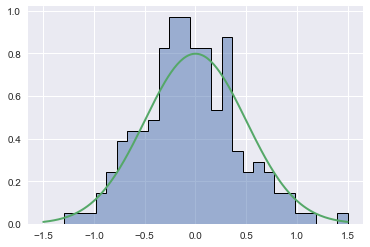

In [16]:
n_gen = 200
Da = generate_mix(n_gen, 1.0, 0.0, np.nan, 0.5, np.nan) # nan values are never used

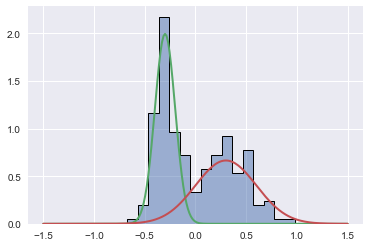

In [17]:
Db = generate_mix(n_gen, 0.5, -0.3, 0.3, 0.1, 0.3)

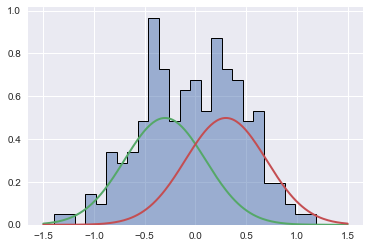

In [18]:
Dc = generate_mix(n_gen, 0.5, -0.3, 0.3, 0.4, 0.4)

Note that each sample has an integer number of entries drawn from each Gaussian, so the true `frac1` is only realized on average.

We will compare two models to explain this data:
 - M1: A single Gaussian with unknown mean $\mu$ and sigma $\sigma$.
 - M2: Two Gaussians with equal proportions (`frac1=0.5`), means with a fixed separation $\mu_2 - \mu_1 = 0.6$, and unknown sigmas $\sigma_1$, $\sigma_2$.
 
Note that Da is drawn from M1 and Db, Dc are drawn from M2.

**DISCUSS:** For each of these three datasets, predict whether the Bayes' factor for M1 relative to M2 will be:
 - Much larger than 1, i.e., strongly favoring M1.
 - About 1, i.e. unable to discriminate between M1 and M2 based on the data alone.
 - Much smaller than 1, i.e., strongly favoring M2.
 
Explain your reasoning.

Da should strongly favor M1 since the fixed separation of the M2 means makes it very unlikely to have been generated by M2.

Db should very strongly favor M2, since no reasonable statistical fluctuation of M1 would ever reproduce it.

Dc should be unable to discriminate between M1 and M2 since, although it was produced by M2, M1 might produce data like this with the right statistical fluctuations.

[Jeffreys proposed a scale](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation) for thresholds in the Bayes' factor:
 - larger than 100 is "decisive evidence" in favor of M1.
 - larger than 10 is "strong evidence" in favor of M1.
 - smaller than 0.1 is "strong evidence" in favor of M2.
 - smaller than 0.01 is "decisive evidence" in favor of M2.

---

To compare models for given data $D$, we perform the following steps for each candidate model $M$:
 - Perform a Bayesian inference with HMC assuming $M$ to obtain samples of $(\mu, \sigma)$ drawn from the posterior $P(\theta\mid D, M)$.
 - Construct a density estimate of the posterior using the generated samples.
 - Estimate the evidence $P(D\mid M)$ for $D$ given $M$ using the density estimate.

Once we have estimated the evidence for each model, we can calculate the Bayes' factor for any pair of models.

The final step is to assign relative prior probabilities for each model in order to calculate the odds ratios.

The following parameter ranges are enforced by setting the prior probability to zero outside these ranges:
 - M1: $|\mu| \le 1$ and $0.05 \le \sigma \le 1.0$.
 - M2: $|\mu| \le 1$ and $0.05 \le \sigma_i \le 1.0$, with $\mu \equiv (\mu_1 + \mu_2) / 2$.

In [19]:
mu_range = (-1., +1.)
sigma_range = (0.05, 1.0)

The code below to calculate the evidence assuming M1 is quite involved, and brings together several topics we have met already:
 - Bayesian inference.
 - Tensorflow and Edward frameworks.
 - Hamiltonian Markov-chain Monte Carlo.
 - Density estimation.
 - Evidence estimation with MCMC samples.
 
Do not worry about the details, at least until you need to perform a similar calculation yourself!

In [20]:
def calculate_M1_evidence(D, n_mc=2000, n_grid=50, seed=123):
    # --------------------------------------------------------------------------
    # Pick intial point for MCMC chains based on the data.
    # --------------------------------------------------------------------------
    lo, med, hi = np.percentile(D, (16, 50, 84))
    mu_init = np.float32(med)
    t_init = np.float32(np.log(0.5 * (hi - lo)))
    # --------------------------------------------------------------------------
    # Build the graph for this inference.
    # --------------------------------------------------------------------------
    M1_graph = tf.Graph()
    with M1_graph.as_default():
        mu = ed.models.Uniform(*mu_range)
        t = ed.models.Uniform(*np.log(sigma_range, dtype=np.float32))
        X = ed.models.Normal(loc=tf.fill(D.shape, mu), scale=tf.fill(D.shape, tf.exp(t)))
        mc_mu = ed.models.Empirical(params=tf.Variable(tf.fill((n_mc,), mu_init)))
        mc_t = ed.models.Empirical(params=tf.Variable(tf.fill((n_mc,), t_init)))
    # --------------------------------------------------------------------------
    # Run the inference using HMC to generate samples.
    # --------------------------------------------------------------------------
    with tf.Session(graph=M1_graph) as session:
        tf.set_random_seed(seed)
        inference = ed.HMC({mu: mc_mu, t: mc_t}, data={X: D})
        inference.run(step_size=0.01, n_steps=10)
        mu_samples, t_samples = session.run([mc_mu.params, mc_t.params])
    # Create a dataframe of the generated samples.
    samples = pd.DataFrame({'mu': mu_samples, 'sigma': np.exp(t_samples)})
    # --------------------------------------------------------------------------
    # Build a parameter grid for estimating the evidence.
    # --------------------------------------------------------------------------
    mu_grid = np.linspace(*np.percentile(mu_samples, (0.5, 99.5)), n_grid)
    sigma_grid = np.linspace(*np.exp(np.percentile(t_samples, (0.5, 99.5))), n_grid)
    # --------------------------------------------------------------------------
    # Evaluate the posterior numerator P(D|mu,sigma) P(mu,sigma) on the grid.
    # --------------------------------------------------------------------------
    sigma_ = sigma_grid.reshape(-1, 1)
    D_ = D.reshape(-1, 1, 1)
    log_numerator_grid = scipy.stats.norm.logpdf(D_, mu_grid, sigma_).sum(axis=0)
    log_numerator_grid -= np.log(sigma_)
    # --------------------------------------------------------------------------
    # Estimate the posterior density from the generated samples with a GMM.
    # --------------------------------------------------------------------------
    fit = mixture.GaussianMixture(n_components=1).fit(samples)
    # --------------------------------------------------------------------------
    # Evaluate the density on the grid.
    # --------------------------------------------------------------------------
    log_density_grid = np.empty((n_grid, n_grid))
    for i1, mu_value in enumerate(mu_grid):
        for i2, sigma_value in enumerate(sigma_grid):
            log_density_grid[i2, i1] = fit.score_samples([[mu_value, sigma_value]])[0]
    # --------------------------------------------------------------------------
    # Use the the 25% of grid points with the largest numerator for the evidence estimate.
    # --------------------------------------------------------------------------
    log_numerator_cut = np.percentile(log_numerator_grid, 75)
    use = log_numerator_grid > log_numerator_cut
    log_evidence = np.median((log_numerator_grid - log_density_grid)[use])
    # --------------------------------------------------------------------------
    # Summarize the results with a plot
    # --------------------------------------------------------------------------
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].scatter(samples['mu'], samples['sigma'], s=5, lw=0, c='k')
    ax[0].contour(mu_grid, sigma_grid, np.max(log_numerator_grid) - log_numerator_grid,
                  levels=[1, 2, 4, 8], colors='k', linewidths=2, linestyles='-')
    ax[0].contour(mu_grid, sigma_grid, np.max(log_density_grid) - log_density_grid,
                  levels=[1, 2, 4, 8], colors='r', linewidths=2, linestyles='--')
    ax[0].set_xlim(mu_grid[0], mu_grid[-1])
    ax[0].set_ylim(sigma_grid[0], sigma_grid[-1])
    ax[0].set_xlabel('$\mu$')
    ax[0].set_ylabel('$\sigma$')
    ax[1].scatter(log_numerator_grid.flatten(),
                  (log_numerator_grid - log_density_grid).flatten(),
                  s=5, lw=0, c='r')
    ax[1].scatter(log_numerator_grid[use].flatten(),
                  (log_numerator_grid - log_density_grid)[use].flatten(),
                  s=5, lw=0, c='g')
    ax[1].axhline(log_evidence, c='g')
    ax[1].set_xlabel('$\log P(D\mid \mu,\sigma, M_1) + \log P(\mu,\sigma\mid M_1)$')
    ax[1].set_ylabel('$\log P(D\mid M_1)$')
    plt.subplots_adjust(wspace=0.22)
    return log_evidence

2000/2000 [100%] ██████████████████████████████ Elapsed: 11s | Acceptance Rate: 0.997


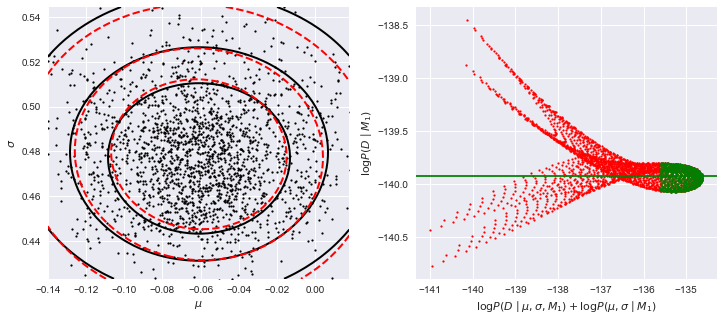

In [21]:
E_Da_M1 = calculate_M1_evidence(Da)

2000/2000 [100%] ██████████████████████████████ Elapsed: 10s | Acceptance Rate: 0.990


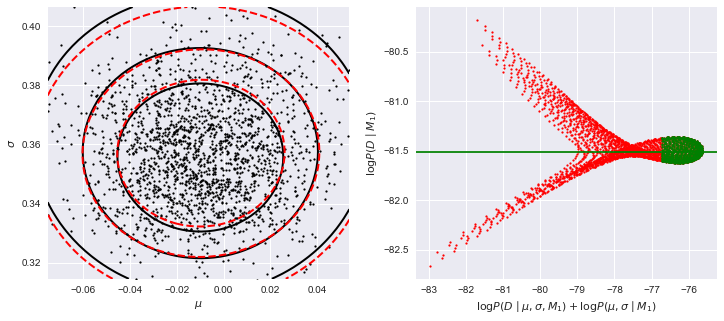

In [22]:
E_Db_M1 = calculate_M1_evidence(Db)

2000/2000 [100%] ██████████████████████████████ Elapsed: 10s | Acceptance Rate: 0.997


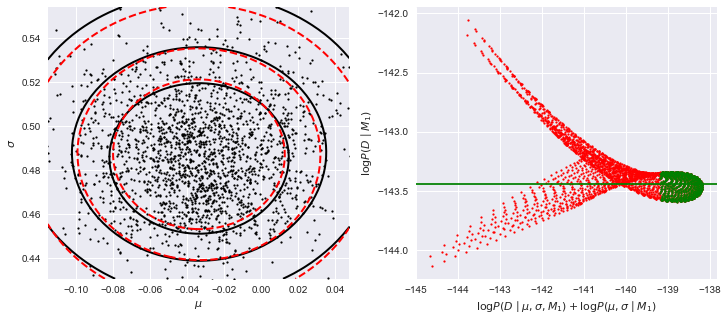

In [23]:
E_Dc_M1 = calculate_M1_evidence(Dc)

In [24]:
def calculate_M2_evidence(D, n_mc=5000, n_grid=25, seed=123, dmu=0.3):
    # --------------------------------------------------------------------------
    # Pick starting point for MCMC chains based on the data.
    # --------------------------------------------------------------------------
    lo, med, hi = np.percentile(D, (16, 50, 84))
    mu_init = np.float32(med)
    t_init = np.float32(np.log(0.3 * (hi - lo)))
    # --------------------------------------------------------------------------
    # Build the graph for this inference.
    # --------------------------------------------------------------------------
    M1_graph = tf.Graph()
    with M1_graph.as_default():
        mu = ed.models.Uniform(*mu_range)
        t1 = ed.models.Uniform(*np.log(sigma_range, dtype=np.float32))
        t2 = ed.models.Uniform(*np.log(sigma_range, dtype=np.float32))
        X1 = ed.models.Normal(loc=tf.fill(D.shape, mu - dmu), scale=tf.fill(D.shape, tf.exp(t1)))
        X2 = ed.models.Normal(loc=tf.fill(D.shape, mu + dmu), scale=tf.fill(D.shape, tf.exp(t2)))
        X = ed.models.Mixture(
            cat=ed.models.Categorical(probs=np.full(D.shape + (2,), 0.5, dtype=np.float32)),
            components=[X1, X2])
        mc_mu = ed.models.Empirical(params=tf.Variable(tf.fill((n_mc,), mu_init)))
        mc_t1 = ed.models.Empirical(params=tf.Variable(tf.fill((n_mc,), t_init)))
        mc_t2 = ed.models.Empirical(params=tf.Variable(tf.fill((n_mc,), t_init)))
    # --------------------------------------------------------------------------
    # Run the inference using HMC to generate samples.
    # --------------------------------------------------------------------------
    with tf.Session(graph=M1_graph) as session:
        tf.set_random_seed(seed)
        inference = ed.HMC({mu: mc_mu, t1: mc_t1, t2: mc_t2}, data={X: D})
        inference.run(step_size=0.01, n_steps=10)
        mu_samples, t1_samples, t2_samples = session.run([mc_mu.params, mc_t1.params, mc_t2.params])
    samples = pd.DataFrame({'mu': mu_samples, 'sigma1': np.exp(t1_samples), 'sigma2': np.exp(t2_samples)})
    # --------------------------------------------------------------------------
    # Build a parameter grid for estimating the evidence.
    # --------------------------------------------------------------------------
    mu_grid = np.linspace(*np.percentile(mu_samples, (0.5, 99.5)), n_grid)
    sigma1_grid = np.linspace(*np.exp(np.percentile(t1_samples, (0.5, 99.5))), n_grid)
    sigma2_grid = np.linspace(*np.exp(np.percentile(t2_samples, (0.5, 99.5))), n_grid)
    # --------------------------------------------------------------------------
    # Evaluate the posterior numerator P(D|mu,sigma1,sigma2) P(mu,sigma1,sigma2) on the grid.
    # --------------------------------------------------------------------------
    mu1_, mu2_ = mu_grid - dmu, mu_grid + dmu
    sigma1_ = sigma1_grid.reshape(-1, 1)
    sigma2_ = sigma2_grid.reshape(-1, 1, 1)
    D_ = D.reshape(-1, 1, 1, 1)
    log_numerator_grid = np.log(0.5 * (
        scipy.stats.norm.pdf(D_, mu1_, sigma1_) +
        scipy.stats.norm.pdf(D_, mu2_, sigma2_))).sum(axis=0)
    log_numerator_grid -= np.log(sigma1_) + np.log(sigma2_)
    # --------------------------------------------------------------------------
    # Calculate projections onto each pair of parameters with numerical 1D integration.
    # --------------------------------------------------------------------------
    numerator_grid = np.exp(log_numerator_grid)
    proj_mu_sigma1 = np.log(np.trapz(numerator_grid, sigma2_grid, axis=0))
    proj_mu_sigma2 = np.log(np.trapz(numerator_grid, sigma1_grid, axis=1))
    proj_sigma1_sigma2 = np.log(np.trapz(numerator_grid, mu_grid, axis=2))
    # --------------------------------------------------------------------------
    # Estimate the posterior density from the generated samples with a GMM.
    # --------------------------------------------------------------------------
    fit = mixture.GaussianMixture(n_components=3).fit(samples)
    # --------------------------------------------------------------------------
    # Evaluate the density on the grid.
    # --------------------------------------------------------------------------
    log_density_grid = np.empty((n_grid, n_grid, n_grid))
    for i1, mu_value in enumerate(mu_grid):
        for i2, sigma1_value in enumerate(sigma1_grid):
            for i3, sigma2_value in enumerate(sigma2_grid):
                log_density_grid[i3, i2, i1] = fit.score_samples([[mu_value, sigma1_value, sigma2_value]])[0]
    # --------------------------------------------------------------------------
    # Calculate projections onto each pair of parameters with numerical 1D integration.
    # --------------------------------------------------------------------------
    density_grid = np.exp(log_density_grid)
    dproj_mu_sigma1 = np.log(np.trapz(density_grid, sigma2_grid, axis=0))
    dproj_mu_sigma2 = np.log(np.trapz(density_grid, sigma1_grid, axis=1))
    dproj_sigma1_sigma2 = np.log(np.trapz(density_grid, mu_grid, axis=2))
    # --------------------------------------------------------------------------
    # Use the the 5% of grid points with the largest numerator for the evidence estimate.
    # --------------------------------------------------------------------------
    log_numerator_cut = np.percentile(log_numerator_grid, 95)
    use = log_numerator_grid > log_numerator_cut
    log_evidence = np.median((log_numerator_grid - log_density_grid)[use])
    # --------------------------------------------------------------------------
    # Summarize the results with a plot
    # --------------------------------------------------------------------------
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    ax = ax.flatten()
    ax[0].scatter(samples['mu'], samples['sigma1'], s=3, lw=0, c='k')
    ax[0].contour(mu_grid, sigma1_grid, np.max(proj_mu_sigma1) - proj_mu_sigma1,
                  levels=[1, 2, 4, 8], colors='k', linewidths=2, linestyles='-')
    ax[0].contour(mu_grid, sigma1_grid, np.max(dproj_mu_sigma1) - dproj_mu_sigma1,
                  levels=[1, 2, 4, 8], colors='r', linewidths=2, linestyles='--')
    ax[0].set_xlim(mu_grid[0], mu_grid[-1])
    ax[0].set_ylim(sigma1_grid[0], sigma1_grid[-1])
    ax[0].set_xlabel('$\mu$')
    ax[0].set_ylabel('$\sigma_1$')
    ax[2].scatter(samples['mu'], samples['sigma2'], s=3, lw=0, c='k')
    ax[2].contour(mu_grid, sigma2_grid, np.max(proj_mu_sigma2) - proj_mu_sigma2,
                  levels=[1, 2, 4, 8], colors='k', linewidths=2, linestyles='-')
    ax[2].contour(mu_grid, sigma2_grid, np.max(dproj_mu_sigma2) - dproj_mu_sigma2,
                  levels=[1, 2, 4, 8], colors='r', linewidths=2, linestyles='--')
    ax[2].set_xlim(mu_grid[0], mu_grid[-1])
    ax[2].set_ylim(sigma2_grid[0], sigma2_grid[-1])
    ax[2].set_xlabel('$\mu$')
    ax[2].set_ylabel('$\sigma_2$')
    ax[3].scatter(samples['sigma1'], samples['sigma2'], s=3, lw=0, c='k')
    ax[3].contour(sigma1_grid, sigma2_grid, np.max(proj_sigma1_sigma2) - proj_sigma1_sigma2,
                  levels=[1, 2, 4, 8], colors='k', linewidths=2, linestyles='-')
    ax[3].contour(sigma1_grid, sigma2_grid, np.max(dproj_sigma1_sigma2) - dproj_sigma1_sigma2,
                  levels=[1, 2, 4, 8], colors='r', linewidths=2, linestyles='--')
    ax[3].set_xlim(sigma1_grid[0], sigma1_grid[-1])
    ax[3].set_ylim(sigma2_grid[0], sigma2_grid[-1])
    ax[3].set_xlabel('$\sigma_1$')
    ax[3].set_ylabel('$\sigma_2$')
    ax[1].scatter(log_numerator_grid.flatten(),
                  (log_numerator_grid - log_density_grid).flatten(),
                  s=5, lw=0, c='r')
    ax[1].scatter(log_numerator_grid[use].flatten(),
                  (log_numerator_grid - log_density_grid)[use].flatten(),
                  s=5, lw=0, c='g')
    ax[1].axhline(log_evidence, c='g')
    ax[1].set_xlabel('$\log P(D\mid \mu,\sigma_1,\sigma_2, M_2) + \log P(\mu,\sigma_1,\sigma_2\mid M_2)$')
    ax[1].set_ylabel('$\log P(D\mid M_2)$')
    plt.subplots_adjust(wspace=0.22)
    
    return log_evidence

5000/5000 [100%] ██████████████████████████████ Elapsed: 34s | Acceptance Rate: 0.998


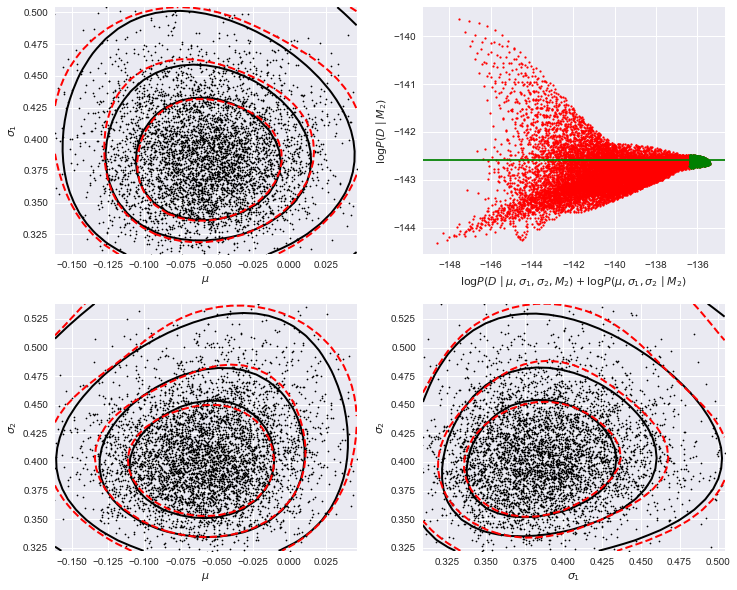

In [25]:
E_Da_M2 = calculate_M2_evidence(Da)

5000/5000 [100%] ██████████████████████████████ Elapsed: 34s | Acceptance Rate: 0.968


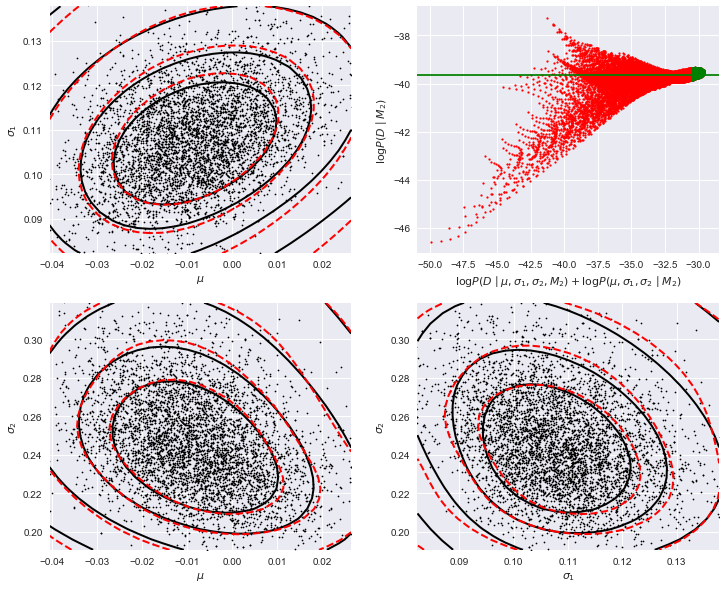

In [26]:
E_Db_M2 = calculate_M2_evidence(Db)

5000/5000 [100%] ██████████████████████████████ Elapsed: 33s | Acceptance Rate: 0.998


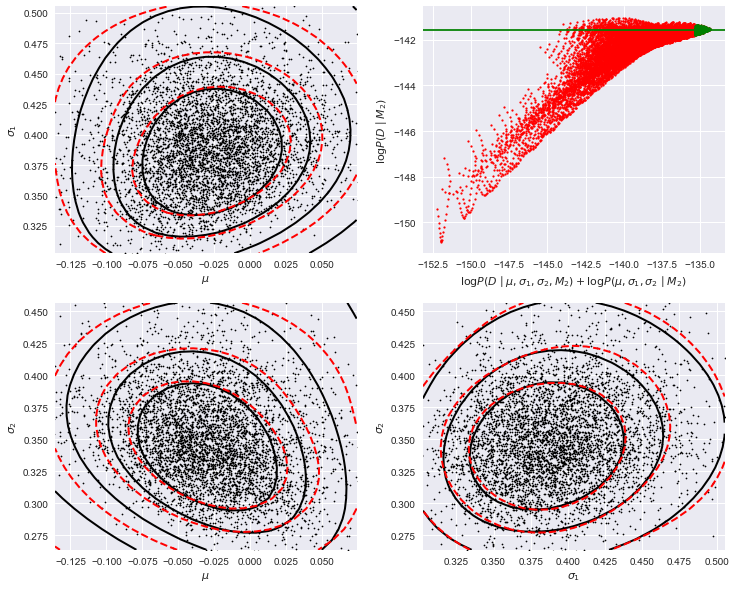

In [27]:
E_Dc_M2 = calculate_M2_evidence(Dc)

Each of these involved calculations provides a single number, the estimated log of the evidence for $D$ given $M$,
$$
\log P(D\mid M)
$$
Note these are tiny numbers ($e^{-100} \simeq 10^{-44}$), but it their difference that matters:
$$
\text{Bayes' factor} = \exp\left[ \log P(D\mid M_1) - \log P(D\mid M_2)\right] \; .
$$
Finally, we apply our subjective prior weights for relative likelihood of M1 and M2 in the absence of any data to obtain the M1:M2 odds ratio:
$$
\frac{P(M_1\mid D)}{P(M_2\mid D)} = (\text{Bayes' factor}) \times \frac{P(M_1)}{P(M_2)} \; .
$$

If we assume that M1 and M2 have equal a-priori weights, then the odds ratio equals the Bayes' factor:

In [28]:
def summarize(M1_prior=0.5, M2_prior=0.5):
    results = pd.DataFrame({
        'logM1': [E_Da_M1, E_Db_M1, E_Dc_M1],
        'logM2': [E_Da_M2, E_Db_M2, E_Dc_M2]},
        index=('Da', 'Db', 'Dc'))
    results['Bayes'] = np.exp(results['logM1'] - results['logM2'])
    results['Odds'] = results['Bayes'] * M1_prior / M2_prior
    return results.round(2)
    
summarize()

,logM1,logM2,Bayes,Odds
Da,-139.92,-142.59,14.43,14.43
Db,-81.51,-39.63,0.00,0.00
Dc,-143.44,-141.55,0.15,0.15


To summarize in words:
 - M1 is "strongly" (but not "decisively") by Da.
 - M2 is "decisively" supported by Db.
 - M2 is mildy supported by Dc, but the evidence is not "strong".